In [29]:
import numpy as np
import matplotlib.pyplot as plt

import numpy.polynomial.polynomial as poly
import astropy
from   astropy.timeseries import LombScargle
from   astropy.io import fits as pyfits
from   scipy.interpolate import UnivariateSpline

import sys
import os
import importlib as imp
import warnings
import argparse
import json
from   timeit import default_timer as timer

import pymc3 as pm
import pymc3_ext as pmx
import exoplanet as exo
import aesara_theano_fallback.tensor as T
from   aesara_theano_fallback import aesara as theano
from   celerite2.theano import GaussianProcess
from   celerite2.theano import terms as GPterms

from alderaan.constants import *
from alderaan.utils import *
from alderaan.Planet import *
from alderaan.LiteCurve import *
import alderaan.io as io

# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

# Manually set I/O parameters
#### User should manually set MISSION, TARGET, PRIMARY_DIR,  and CSV_FILE

In [2]:
# here's where you can hard code in mission, target, and paths
MISSION = "Kepler"
TARGET  = "K04034"
PRIMARY_DIR = '/Users/research/projects/alderaan/'

USE_HBM = False
MAX_GROUP_SIZE = 16
MIN_GROUP_SIZE = 8
INTERLACE = False

In [3]:
# here's where we parse the inputs from an sbatch script
try:
    parser = argparse.ArgumentParser(description="Inputs for ALDERAAN transit fiting pipeline")
    parser.add_argument("--mission", default=None, type=str, required=True, \
                        help="Mission name")
    parser.add_argument("--target", default=None, type=str, required=True, \
                        help="Target name; see ALDERAAN documentation for acceptable formats")
    parser.add_argument("--primary_dir", default=None, type=str, required=True, \
                        help="Primary directory path for accessing lightcurve data and saving outputs")
    
    args = parser.parse_args()
    MISSION     = args.mission
    TARGET      = args.target
    PRIMARY_DIR = args.primary_dir
    
except:
    pass

usage: ipykernel_launcher.py [-h] --mission MISSION --target TARGET
                             --primary_dir PRIMARY_DIR
ipykernel_launcher.py: error: the following arguments are required: --mission, --target, --primary_dir


# Make sure the necessary paths exist

In [4]:
# directory in which to find lightcurve data
#if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
#if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs    
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR     = PRIMARY_DIR + 'Traces/' + TARGET + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + TARGET + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + TARGET + '/'
NOISE_DIR     = PRIMARY_DIR + 'Noise_models/' + TARGET + '/'

# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)
    
if os.path.exists(NOISE_DIR) == False:
    os.mkdir(NOISE_DIR)

# Get shape model posteriors

In [5]:
TRACE_FILE = TRACE_DIR + TARGET + '_transit_shape.fits'

In [6]:
with pyfits.open(TRACE_FILE) as trace:
    print(trace.info())

Filename: /Users/research/projects/alderaan/Traces/K04034/K04034_transit_shape.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  LOG_ROR       1 ImageHDU         8   (2, 4000)   float64   
  2  LOG_DUR       1 ImageHDU         8   (2, 4000)   float64   
  3  C0            1 ImageHDU         8   (2, 4000)   float64   
  4  C1            1 ImageHDU         8   (2, 4000)   float64   
  5  FLUX0         1 ImageHDU         8   (15, 4000)   float64   
  6  LOGJIT        1 ImageHDU         8   (15, 4000)   float64   
  7  Q_LIMBDARK    1 ImageHDU         8   (2, 4000)   float64   
  8  U             1 ImageHDU         8   (2, 4000)   float64   
  9  ROR           1 ImageHDU         8   (2, 4000)   float64   
 10  RP            1 ImageHDU         8   (2, 4000)   float64   
 11  BETA          1 ImageHDU         8   (2, 4000)   float64   
 12  B             1 ImageHDU         8   (2, 4000)   float64   
 13  DUR           1 

In [7]:
# Read in the fits file with saved traces

with pyfits.open(TRACE_FILE) as trace:
    header  = trace[0].header
    hdulist = pyfits.HDUList(trace)
    
    NDRAWS, NPL = trace['P'].shape
    
    # limb darkening parameters
    U_LIMBDARK = trace['U'].data
    Q_LIMBDARK = trace['Q_LIMBDARK'].data
    
    # basis parameters
    C0 = trace['C0'].data
    C1 = trace['C1'].data
    BETA = trace['BETA'].data
    LOG_ROR = trace['LOG_ROR'].data/np.log(10)
    LOG_DUR = trace['LOG_DUR'].data/np.log(10)
    
    # physical parameters
    P   = trace['P'].data
    T0  = trace['T0'].data
    RP  = trace['RP'].data*RSRE
    B   = trace['B'].data
    RHO = trace['RHO'].data
    DUR = trace['DUR'].data
    
    # TTV parameters
    TTS = [None]*NPL

    for npl in range(NPL):    
        TTS[npl] = trace['TTS_{0}'.format(npl)].data

In [8]:
RSTAR = 3.53

# Set fixed values for star and planet parameters

In [9]:
basis = [C0, C1, BETA, LOG_ROR, LOG_DUR]

# identify which sample is closest to the median for all parameters
dist_sq = np.zeros(NDRAWS)


for i, var in enumerate(basis):
    for npl in range(NPL):
        dist_sq += ((var[:,npl] - np.median(var[:,npl]))/np.std(var[:,npl]))**2
        
loc = np.argmin(dist_sq)

In [10]:
# grab star and planet parameters for that sample
u = U_LIMBDARK[loc]

periods = np.array(P[loc], dtype="float")
epochs = np.array(T0[loc], dtype="float")
radii = np.array(RP[loc], dtype="float")
impacts = np.array(B[loc], dtype="float")
rho_circs = np.array(RHO[loc], dtype="float")
durs = np.array(DUR[loc], dtype="float")

# Read in detrended lightcurves and QuickTTV estimates

In [11]:
# Load detrended lightcurves
try:
    lc = io.load_detrended_lightcurve(DLC_DIR + TARGET + '_lc_detrended.fits')
except:
    lc = None
    
try:
    sc = io.load_detrended_lightcurve(DLC_DIR + TARGET + '_sc_detrended.fits')
except:
    sc = None

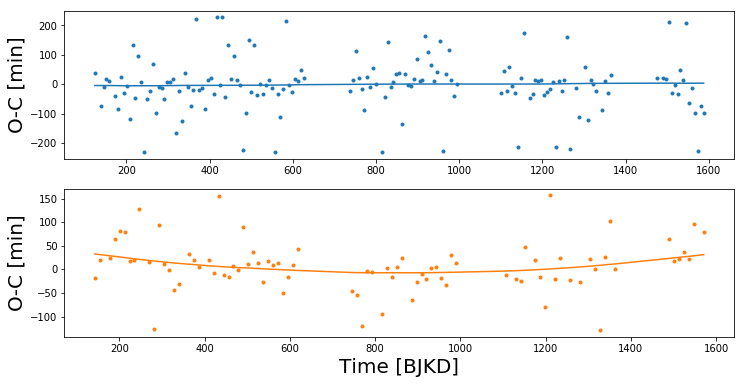

In [18]:
transit_inds = []
ephemeris = []

quick_transit_times = []
map_transit_times = []


# load Quick TTVs
for npl in range(NPL):
    fname_in = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_quick_ttvs.txt'
    data_in  = np.genfromtxt(fname_in)
    
    quick_transit_times.append(np.array(data_in[:,1], dtype="float"))
    
    transit_inds.append(np.array(data_in[:,0], dtype="int"))
    ephemeris.append(poly.polyval(transit_inds[npl], [epochs[npl], periods[npl]]))
    
    #pfit = poly.polyfit(transit_inds[npl], quick_transit_times[npl], 1)
    #epochs[npl] = pfit[0]
    #periods[npl] = pfit[1]
    
    

# load MAP TTVs
for npl in range(NPL):
    fname_in = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_map_ttvs.txt'
    data_in  = np.genfromtxt(fname_in)
    
    map_transit_times.append(np.array(data_in[:,1], dtype="float"))    
    
    
    
    
fig, axes = plt.subplots(NPL, figsize=(12,3*NPL))

for npl in range(NPL):
    xtime = ephemeris[npl]
    yomc_q = (quick_transit_times[npl] - ephemeris[npl])*24*60
    yomc_m = (map_transit_times[npl] - ephemeris[npl])*24*60
    
    axes[npl].plot(xtime, yomc_q, '-', c='C{0}'.format(npl))
    axes[npl].plot(xtime, yomc_m, '.', c='C{0}'.format(npl))
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.show()

In [20]:
# get estimate of ttv uncertainty and a reasonable buffer
ttv_rms_amp = np.zeros(NPL)

for npl in range(NPL):
    ttv_rms_amp[npl] = np.std(map_transit_times[npl] - ephemeris[npl])

# Set up noise GP

In [21]:
# Read in noise model GP priors
gp_percs = []

for z in range(4):
    try:
        fname_in = NOISE_DIR + TARGET + '_shoterm_gp_priors_{0}.txt'.format(z)

        with open(fname_in) as infile:
            gp_percs.append(json.load(infile))

    except:
        gp_percs.append(None)

In [22]:
gp_priors = []

for z in range(4):
    if gp_percs[z] is not None:
        # set GP priors baed on outputs of alderaan.detrend_and_estimate_noise
        # expected for any season with short cadence data
        gpz = {}

        for k in gp_percs[z].keys():
            if k != "percentiles":
                perc = np.array(gp_percs[z]['percentiles'])

                med = np.array(gp_percs[z][k])[perc == 50.0][0]
                err1 = np.array(gp_percs[z][k])[perc == 84.135][0]
                err2 = np.array(gp_percs[z][k])[perc == 15.865][0]

                dev = np.sqrt((err1-med)**2/2 + (err2-med)**2/2)

                gpz[k] = (med, dev)

        gp_priors.append(gpz)
        
    else:
        # these are dummy values that effectively create a zero-amplitude kernel
        gpz = {}
        gpz['logw0'] = [np.log(2*pi/(7*DURS.max()))]
        gpz['logSw4'] = [-100.]
        gpz['logQ'] = [np.log(1/np.sqrt(2))]
        
        gp_priors.append(gpz)

In [23]:
for z in range(4):
    gpz = gp_priors[z]
    
    logS = gpz["logSw4"][0] - 4*gpz["logw0"][0]
    
    if len(gpz["logSw4"]) == 1:
        gp_priors[z]["logS"] = np.copy(logS)
        
    if len(gpz["logSw4"]) == 2:
        logS_var = gpz["logSw4"][1]**2 + 16*gpz["logw0"][1]**2
        gp_priors[z]["logS"] = np.array([logS, np.sqrt(logS_var)])

# Determine time baseline

In [24]:
time_min = []
time_max = []

if lc is not None:
    time_min.append(lc.time.min())
    time_max.append(lc.time.max())

if sc is not None:
    time_min.append(sc.time.min())
    time_max.append(sc.time.max())

TIME_START = np.min(time_min)
TIME_END   = np.max(time_max)

if TIME_START < 0:
    raise ValueError("START TIME [BKJD] is negative...this will cause problems")

# Break the transits into subgroups
#### Groups are indexed starting at 1, with 0 reserved for overlapping transits


PLANET 0
lowest BIC at polyorder = 1

PLANET 1
periodic component found at P =  60 d


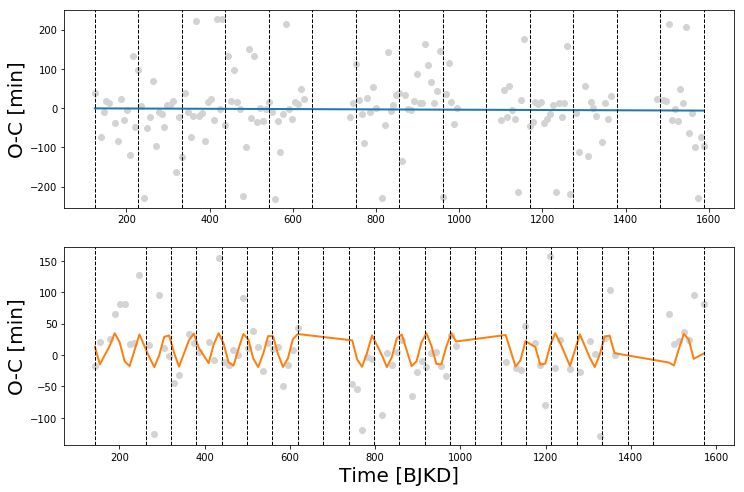

In [30]:
tts_group = []
local_trend_type = []
sin_priors = []

fig, axes = plt.subplots(NPL, figsize=(12,8))


for npl in range(NPL):
    print("\nPLANET", npl)
    
    xtime = ephemeris[npl]
    yomc  = (map_transit_times[npl] - ephemeris[npl])
    
    ntrans = len(xtime)
    peakfreq = None

    # search for a period component
    try:
        xf, yf, freqs, faps, levels = LS_estimator(xtime, yomc, return_levels=True)

        if len(freqs) > 0:
            if freqs[0] > xf.min():
                peakfreq = freqs[0]
                
    except:
        pass
        
        
    # roughly model OMC based on single frequency sinusoid (if found)
    if peakfreq is not None:
        trend_type = "sinusoid"

        print("periodic component found at P = ", int(1/peakfreq), "d")
        
        LS = LombScargle(xtime, yomc)
        
        trend = LS.model(xtime, peakfreq)
        _, Asin, Bcos = LS.model_parameters(peakfreq)
        
        sin_priors.append((peakfreq, Asin, Bcos))
        
        edges = [xtime.min()-0.5, xtime.max()+0.5]
        ngroups = int(np.ceil((xtime.max()-xtime.min())*peakfreq))

        for i in range(1,ngroups):
            edges.append(xtime.min()+i/ngroups*(xtime.max()-xtime.min()))
            
        edges = list(np.sort(edges))
        
    
    # otherwise, chose best polynomial model based on the BIC
    else:
        trend_type = "polynomial"
        sin_priors.append(None)
        
        biclist = []
        for i in range(1, int(np.ceil(np.sqrt(ntrans)))):
            poly_coeffs = poly.polyfit(xtime, yomc, i)
            poly_trend = poly.polyval(xtime, poly_coeffs)

            RSS = np.sum((yomc-poly_trend)**2)
            BIC = ntrans*np.log(RSS/ntrans) + (i+1)*np.log(ntrans)

            biclist.append(BIC)

        polyorder = np.argmin(biclist)+1
        trend = np.polyval(np.polyfit(xtime, yomc, polyorder), xtime)

        print("lowest BIC at polyorder = {0}".format(polyorder))


        # fit a spline and find inflecton points
        if polyorder > 2:
            spline = UnivariateSpline(xtime, trend, k=5)
            inflects = spline.derivative(2).roots()
            curvature = np.array(np.sign(spline.derivative(2)(xtime)), dtype="int")

            # define edges of groups
            edges = np.hstack([xtime.min()-0.5, inflects, xtime.max()+0.5])
            edges = list(np.sort(edges))
            
        else:
            curvature = np.zeros(len(trend), dtype="int")
            
            edges = [xtime.min()-0.5, xtime.max()+0.5]

        
    # makes sure the groups are not too small (i.e. edges near endpoints)
    if len(edges) > 2:
        if int((edges[-1]-edges[-2])/periods[npl]) < MIN_GROUP_SIZE:
            edges.remove(edges[-2])
        if int((edges[1]-edges[0])/periods[npl]) < MIN_GROUP_SIZE:
            edges.remove(edges[1])

    if len(edges) < 2:
        raise ValueError("There should be at least two edges to indicate endpoints")


    # make sure the groups are not too big
    for i in range(len(edges)-1):
        count = int(np.ceil((edges[i+1]-edges[i])/periods[npl]/MAX_GROUP_SIZE))

        for j in range(1,count):
            new = edges[i] + (j/count)*(edges[i+1]-edges[i])
            edges.append(new)

    edges = np.sort(edges)


    # assign each transit to a group
    tg = np.zeros(ntrans, dtype="int")
    
    for edj in edges:
        tg = tg + np.array(xtime >= edj, dtype="int")
        
    tts_group.append(tg)
    
    
    # determine the best local model for each group
    if trend_type == "sinusoid":
        local_trend_type.append(["sinusoid"]*tts_group[npl].max())
    
    
    elif trend_type == "polynomial":
        if polyorder <= 2:
            local_trend_type.append(["linear"]*tts_group[npl].max())
        else:
            local_trend_type.append(["quadratic"]*tts_group[npl].max())
        

    # display the results
    axes[npl].plot(xtime, yomc*24*60, 'o', c='lightgrey')
    axes[npl].plot(xtime, trend*24*60, c='C{0}'.format(npl), lw=2)
    for edj in edges:
        axes[npl].axvline(edj, c='k', lw=1, ls='--')
    axes[npl].set_ylabel('O-C [min]', fontsize=20)
    
axes[NPL-1].set_xlabel('Time [BJKD]', fontsize=20)
plt.show()

In [31]:
if INTERLACE:
    # interlace groups
    for npl in range(NPL):
        for g in range(1, tts_group[npl].max()):

            count = np.min([np.sum(tts_group[npl] == g), np.sum(tts_group[npl] == g+1)])
            loc = np.where(tts_group[npl] == g)[0].max()

            for c in range(np.min([count//6,3])):
                tts_group[npl][loc-2*c] = g+1
                tts_group[npl][loc+2*c+1] = g

# Identify overlapping transits

In [32]:
if lc is not None:
    lc_quarters = np.unique(lc.quarter)
else:
    lc_quarters = np.array([])
    
if sc is not None:
    sc_quarters = np.unique(sc.quarter)
else:
    sc_quarters = np.array([])
    
    
quarters = np.sort(np.hstack([lc_quarters, sc_quarters]))

In [35]:
overlap = []

for i in range(NPL):
    overlap.append(np.zeros(len(ephemeris[i]), dtype='bool'))
    
    for j in range(NPL):
        if i != j:
            for tt in ephemeris[j]:
                overlap[i] += np.abs(ephemeris[i] - tt) < durs.max()
                
                
# assign overlapping transits to group -99
for npl in range(NPL):
    tts_group[npl][overlap[npl]] = -99

# Track which quarter each transit falls in

In [36]:
thresh = np.zeros(len(quarters)+1)

thresh[0] = TIME_START

for j, q in enumerate(quarters):
    if np.isin(q, sc_quarters):
        thresh[j+1] = sc.time[sc.quarter == q].max()
    if np.isin(q, lc_quarters):
        thresh[j+1] = lc.time[lc.quarter == q].max()
        
thresh[0] -= 1.0
thresh[-1] += 1.0

In [38]:
transit_quarter = [None]*NPL

for npl in range(NPL):
    tts = ephemeris[npl]
    transit_quarter[npl] = np.zeros(len(tts), dtype='int')

    for j, q in enumerate(quarters):
        transit_quarter[npl][(tts >= thresh[j])*(tts<thresh[j+1])] = q

# Grab the relevant data

In [39]:
# grab data near transits for each quarter
all_time = [None]*18
all_flux = [None]*18
all_mask = [None]*18
all_dtype = ["none"]*18

lc_flux = []
sc_flux = []


for q in range(18):
    if sc is not None:
        if np.isin(q, sc.quarter):
            use = (sc.mask)*(sc.quarter == q)

            if np.sum(use) > 45:
                all_time[q] = sc.time[use]
                all_flux[q] = sc.flux[use]
                all_mask[q] = sc.mask[use]
                all_dtype[q] = "short"

                sc_flux.append(sc.flux[use])
                
            else:
                all_dtype[q] = "short_no_transits"

    
    if lc is not None:
        if np.isin(q, lc.quarter):
            use = (lc.mask)*(lc.quarter == q)

            if np.sum(use) > 5:
                all_time[q] = lc.time[use]
                all_flux[q] = lc.flux[use]
                all_mask[q] = lc.mask[use]
                all_dtype[q] = "long"

                lc_flux.append(lc.flux[use])
                
            else:
                all_dtype[q] = "long_no_transits"

In [40]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  92 s



# Make photometry masks

In [41]:
import alderaan.detrend as detrend

In [ ]:
if sc is not None:
    sc_mask = np.zeros((NPL,len(sc.time)),dtype='bool')
    for npl in range(NPL):
        sc_mask[npl] = detrend.make_transitmask(sc.time, quick_transit_times[npl], np.max([2/24,1.5*durs[npl]]))

else:
    sc_mask = None

    
if lc is not None:
    lc_mask = np.zeros((NPL,len(lc.time)),dtype='bool')
    for npl, p in enumerate(planets):
        lc_mask[npl] = detrend.make_transitmask(lc.time, p.tts, np.max([2/24,1.5*p.duration]))
        
    lc.mask = lc_mask.sum(axis=0) > 0

else:
    lc_mask = None

In [ ]:
# group mask for non-overlapping transits
group_mask = [None]*18

for q in range(18):
    if all_mask[q] is not None:        
        t_ = all_time[q]
        m_ = np.array(all_mask[q].copy(), dtype="int")
    
        for npl in range(NPL):
            m_ *= 0
            
            for i, t0 in enumerate(quick_map_transit_times[npl]):
                m_[np.abs(t_-t0)/durs[npl] < 3.0] = tts_group[npl][i]
                
        group_mask[q] = np.copy(m_)

In [ ]:
m_[npl][np.abs(t_-t0)/durs[npl] < 3.0]

In [ ]:
# plot non-overlapping tranits each planet, color-coded by group 
for npl in range(NPL):
    plt.figure(figsize=(20,2))
    
    for j, q in enumerate(quarters):        
        t_ = all_time[q]
        f_ = all_flux[q]
        m_ = group_mask[q][npl]
        
        for ng in range(1,tts_group[npl].max()+1):
            plt.plot(t_[m_==ng], f_[m_==ng], ".", c="C{0}".format((ng-1)%10))
        
    plt.show()
    


plt.figure(figsize=(20,3))


# plot all overlapping transits for all planets
for j, q in enumerate(quarters):        
    t_ = all_time[q]
    f_ = all_flux[q]
    m_ = np.sum(group_mask[q] == -99, axis=0) > 0

    for ng in range(1,tts_group[npl].max()+1):
        plt.plot(t_[m_], f_[m_], "k.")


plt.show()

# Fit transit times

In [ ]:
tts_chains = []
offset_chains = []
pop_sd_chains = []
omc_trend_chains = []

for npl in range(NPL):
    for ng in range(1,tts_group[npl].max()+1):
        print("\nPLANET {0}, GROUP {1}".format(npl,ng))
        
        # identify which quarters and which_seasons have data
        use = tts_group[npl] == ng
        
        wq = np.unique(transit_quarter[npl][use])
        ws = np.unique(wq % 4)
                        
        print(np.sum(use), "transits")
        print("quarters:", wq)
        print("local trend:", local_trend_type[npl][ng-1])
        
        # grab transit times
        fixed_tts = np.copy(shape_transit_times[npl][use])
        fixed_inds = np.array(transit_inds[npl][use], dtype="int")
        fixed_ephem = np.copy(shape_ephemeris[npl][use])
        
        fixed_inds -= fixed_inds[0]
                
        # define Legendre polynomials
        x = 2*(fixed_ephem-np.min(fixed_ephem))/(np.max(fixed_ephem)-np.min(fixed_ephem)) - 1
                
        Leg0 = np.ones_like(x)
        Leg1 = x.copy()
        Leg2 = 0.5*(3*x**2 - 1)
        
        
        # now build the model
        with pm.Model() as hbm_model:
            # local trend parameters
            C0 = pm.Normal("C0", mu=0.0, sd=2*ttv_rms_amp[npl])
            C1 = pm.Normal("C1", mu=0.0, sd=2*ttv_rms_amp[npl])
            
            if local_trend_type[npl][ng-1] == "linear":
                C2 = 0.0
                sin_omc = T.zeros(len(fixed_ephem)) 
                
            elif local_trend_type[npl][ng-1] == "quadratic":
                C2 = pm.Normal("C2", mu=0.0, sd=2*ttv_rms_amp[npl])
                sin_omc = T.zeros(len(fixed_ephem)) 

            elif local_trend_type[npl][ng-1] == "sinusoid":
                C2 = 0.0
                
                df = 1/(shape_ephemeris[npl].max()-shape_ephemeris[npl].min())
                
                freq = pm.Normal("freq", mu=sin_priors[npl][0], sd=df)
                A = pm.Normal("A", mu=0, sd=np.sqrt(2)*ttv_rms_amp[npl], testval=sin_priors[npl][1])
                B = pm.Normal("B", mu=0, sd=np.sqrt(2)*ttv_rms_amp[npl], testval=sin_priors[npl][2])
                
                sin_omc = pm.Deterministic("sin_omc", 
                                           A*T.sin(2*pi*freq*fixed_ephem) + 
                                           B*T.cos(2*pi*freq*fixed_ephem))
                
                
            else:
                raise ValueError("local_trend_type must be 'linear', 'quadratic', or 'sinusoid'")
                
                
            # hierarchical (hyper)parameters
            if USE_HBM:
                log_pop_var = pm.Normal('log_pop_var', mu=2*np.log(ttv_rms_amp[npl]), 
                                        sd=np.log(4))
            
                pop_sd = pm.Deterministic('pop_sd', T.sqrt(T.exp(log_pop_var)))
                
            else:
                pop_sd = np.sqrt(2)*ttv_rms_amp[npl]
            
            # transit times
            tt_offset = pm.StudentT('tt_offset', nu=2, shape=len(fixed_ephem))
            
            poly_omc  = pm.Deterministic('poly_omc', C0*Leg0 + C1*Leg1 + C2*Leg2)
            omc_trend = pm.Deterministic('omc_trend', poly_omc + sin_omc)
            
            transit_times = pm.Deterministic('tts', fixed_ephem + omc_trend + tt_offset*pop_sd)
            
                        
            # set up stellar model and planetary orbit
            exoSLC = exo.StarryLightCurve(u)
            orbit  = exo.orbits.TTVOrbit(transit_times=[transit_times], transit_inds=[fixed_inds], 
                                         b=b[npl], r_star=Rstar, m_star=Mstar)

            # track period and epoch
            T0 = pm.Deterministic('T0', orbit.t0)
            P  = pm.Deterministic('P', orbit.period)
            
            # nuissance parameters (one mean flux; variance by quarter)
            flux0 = pm.Normal('flux0', mu=np.ones(len(wq)), sd=np.sqrt(vbq_all[wq])/4, shape=len(wq))
            logvar = pm.Normal('logvar', mu=np.log(vbq_all[wq]), sd=np.log(4)*np.ones(len(wq)), shape=len(wq))

            
            # build the GP kernel using a different noise model for each season
            logSw4 = [None]*4
            logw0  = [None]*4
            logQ   = [None]*4
            kernel = [None]*4

            for i in range(4):
                if np.isin(i, ws):
                    gpi = gp_priors[i]              

                    logSw4[i] = gpi['logSw4'][0]
                    logw0[i] = gpi['logw0'][0]
                    logQ[i] = gpi['logQ'][0]

                    kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
                
                else:
                    kernel[i] = None
            
            
            # now evaluate the model for each quarter
            light_curves       = [None]*len(wq)
            summed_light_curve = [None]*len(wq)
            model_flux         = [None]*len(wq)
            
            gp = [None]*len(wq)
            

            for j, q in enumerate(wq):
                # here's the data
                t_ = all_time[q]
                f_ = all_flux[q]
                m_ = group_mask[q][npl] == ng
                
                # sometimes there is a missing transit (?) in the last quarter
                # I think this is an edge/boundary issue but I haven't been able to locate it
                if np.sum(m_) == 0:
                    warnings.warn("Got unexpected empty data array for PLANET {0}, QUARTER {1}".format(npl,q))
                    
                else:
                    # set oversampling factor
                    if all_dtype[q] == 'short':
                        oversample = 1
                    elif all_dtype[q] == 'long':
                        oversample = 15

                    # calculate light curves
                    light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp[npl], t=t_[m_], oversample=oversample)
                    summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0[j]*T.ones(len(t_[m_]))
                    model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])

                    # here's the GP (w/ kernel by season)
                    gp[j] = exo.gp.GP(kernel[q%4], t_[m_], T.exp(logvar[j])*T.ones(len(t_[m_])))
                
                
                    # add custom potential (log-prob fxn) with the GP likelihood
                    pm.Potential('obs_{0}'.format(j), gp[j].log_likelihood(f_[m_] - model_flux[j]))
                
                
        with hbm_model:
            hbm_map = exo.optimize(start=hbm_model.test_point, vars=[flux0, logvar])

            if local_trend_type[npl][ng-1] == "linear":
                hbm_map = exo.optimize(start=hbm_map, vars=[C0, C1]) 
            if local_trend_type[npl][ng-1] == "quadratic":
                hbm_map = exo.optimize(start=hbm_map, vars=[C0, C1, C2]) 
            if local_trend_type[npl][ng-1] == "sinusoid":
                hbm_map = exo.optimize(start=hbm_map, vars=[C0, C1, A, B])
            
            
        plt.figure(figsize=(12,4))
        plt.plot(fixed_ephem, hbm_map["omc_trend"], c="C{0}".format(npl))
        plt.show()
            
                
        # sample from the posterior
        with hbm_model:
            hbm_trace = pm.sample(tune=2, draws=1, start=hbm_map, chains=2,
                                  step=exo.get_dense_nuts_step(target_accept=0.9))

        # save the results
        omc_trend_chains.append(np.copy(np.array(hbm_trace['omc_trend'])))
        tts_chains.append(np.copy(np.array(hbm_trace['tts'])))
        offset_chains.append(np.copy(np.array(hbm_trace['tt_offset'])))
        
        if USE_HBM:
            pop_sd_chains.append(np.copy(np.array(hbm_trace['pop_sd'])))
        else:
            pop_sd_chains.append(pop_sd*np.ones(hbm_trace['tts'].shape[0]))

# Fit overlapping transits

In [ ]:
overlap_count = 0

for npl in range(NPL):
    overlap_count += np.sum(tts_group[npl]==-99)
    
    
print(overlap_count, "overlapping transits")

In [ ]:
if overlap_count > 0:
    with pm.Model() as overlap_model:
        fixed_tts = []
        fixed_inds = []
        fixed_ephem = []

        which_planets = []
        which_quarters = []


        # grab the relevant data
        for npl in range(NPL):
            use = tts_group[npl] == -99

            if np.sum(use) > 0:
                fixed_tts.append(np.copy(shape_transit_times[npl][use]))
                fixed_inds.append(np.array(transit_inds[npl][use], dtype="int"))
                fixed_ephem.append(np.copy(shape_ephemeris[npl][use]))

                fixed_inds[npl] -= fixed_inds[npl][0]

                which_planets.append(npl)
                which_quarters.append(transit_quarter[npl][use])

        wq = np.unique(np.hstack(which_quarters))
        ws = np.unique(wq % 4)


        # use a fixed scatter parameter for now
        pop_sd = np.sqrt(2)*ttv_rms_amp

        # transit times
        tt_offset = []
        transit_times = []

        for i, npl in enumerate(which_planets):
            tt_offset.append(pm.StudentT('tt_offset_{0}'.format(npl), nu=2, shape=len(fixed_ephem[i])))
            transit_times.append(pm.Deterministic('tts_{0}'.format(npl), fixed_ephem[i] + tt_offset[i]*pop_sd[npl]))


        # set up stellar model and planetary orbit
        exoSLC = exo.StarryLightCurve(u)
        orbit  = exo.orbits.TTVOrbit(transit_times=transit_times, transit_inds=fixed_inds, 
                                     b=b[npl], r_star=Rstar, m_star=Mstar)

        # track period and epoch
        T0 = pm.Deterministic('T0', orbit.t0)
        P  = pm.Deterministic('P', orbit.period)


        # nuissance parameters (one mean flux; variance by quarter)
        flux0 = pm.Normal('flux0', mu=np.ones(len(wq)), sd=np.sqrt(vbq_all[wq])/4, shape=len(wq))
        logvar = pm.Normal('logvar', mu=np.log(vbq_all[wq]), sd=np.log(4)*np.ones(len(wq)), shape=len(wq))



        # build the GP kernel using a different noise model for each season
        logSw4 = [None]*4
        logw0  = [None]*4
        logQ   = [None]*4
        kernel = [None]*4

        for i in range(4):
            if np.isin(i, ws):
                gpi = gp_priors[i]              

                logSw4[i] = gpi['logSw4'][0]
                logw0[i] = gpi['logw0'][0]
                logQ[i] = gpi['logQ'][0]

                kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])

            else:
                kernel[i] = None


        # now evaluate the model for each quarter
        light_curves       = [None]*len(wq)
        summed_light_curve = [None]*len(wq)
        model_flux         = [None]*len(wq)

        gp = [None]*len(wq)


        for j, q in enumerate(wq):
            # here's the data
            t_ = all_time[q]
            f_ = all_flux[q]
            m_ = np.sum(group_mask[q] == -99, axis=0) > 0

            # sometimes there is a missing transit (?) in the last quarter
            # I think this is an edge/boundary issue but I haven't been able to locate it
            if np.sum(m_) == 0:
                warnings.warn("Got unexpected empty data array for PLANET {0}, QUARTER {1}".format(npl,q))

            else:
                # set oversampling factor
                if all_dtype[q] == 'short':
                    oversample = 1
                elif all_dtype[q] == 'long':
                    oversample = 15

                # calculate light curves
                light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=t_[m_], oversample=oversample)
                summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0[j]*T.ones(len(t_[m_]))
                model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])

                # here's the GP (w/ kernel by season)
                gp[j] = exo.gp.GP(kernel[q%4], t_[m_], T.exp(logvar[j])*T.ones(len(t_[m_])))


                # add custom potential (log-prob fxn) with the GP likelihood
                pm.Potential('obs_{0}'.format(j), gp[j].log_likelihood(f_[m_] - model_flux[j]))



    # optimize nuissance variables
    with overlap_model:
        overlap_map = exo.optimize(start=overlap_model.test_point, vars=[flux0, logvar])


    # sample from the posterior
    with overlap_model:
        overlap_trace = pm.sample(tune=2, draws=1, start=overlap_map, chains=2,
                                  step=exo.get_dense_nuts_step(target_accept=0.9))


    for i, npl in enumerate(which_planets):
        tts_chains.append(np.copy(np.array(overlap_trace['tts_{0}'.format(npl)])))
        offset_chains.append(np.copy(np.array(overlap_trace['tt_offset_{0}'.format(npl)])))
        pop_sd_chains.append(pop_sd[npl]*np.ones(overlap_trace['tts_{0}'.format(npl)].shape[0]))
        omc_trend_chains.append(np.zeros_like(overlap_trace['tts_{0}'.format(npl)]))

In [ ]:
# make a list of ordered pairs (npl,group) to help organize the chains
chain_organizer = []

for npl in range(NPL):
    for ng in range(1, 1+tts_group[npl].max()):
        chain_organizer.append((npl,ng))

if overlap_count > 0:
    for i, npl in enumerate(which_planets):
        chain_organizer.append((npl,-99))

In [ ]:
# make primary HDU
primary_hdu = pyfits.PrimaryHDU()
header = primary_hdu.header
header['TARGET'] = TARGET
primary_hdu.header = header
    
# add it to HDU list
hbm_hdulist = []
hbm_hdulist.append(primary_hdu)


# grab all samples from trace
for npl in range(NPL):
    combo_tts = []
    combo_omctrend = []
    combo_offset = []
    combo_pop_sd = []
    combo_groupno = []
    
    for i, chorg in enumerate(chain_organizer):
        if chorg[0] == npl:
            combo_tts.append(tts_chains[i])
            combo_offset.append(offset_chains[i])
            combo_groupno.append(chorg[1]*np.ones(tts_chains[i].shape[1], dtype="int"))
            combo_pop_sd.append(pop_sd_chains[i])
            combo_omctrend.append(omc_trend_chains[i])

        
    combo_tts = np.hstack(combo_tts)
    combo_omctrend = np.hstack(combo_omctrend)
    combo_offset = np.hstack(combo_offset)
    combo_pop_sd = np.vstack(combo_pop_sd).swapaxes(0,1)
    combo_groupno = np.hstack(combo_groupno)

    order = np.argsort(np.nanmedian(combo_tts,0))

    combo_tts = combo_tts[:,order]
    combo_omctrend = combo_omctrend[:,order]
    combo_offset = combo_offset[:,order]
    combo_groupno = combo_groupno[order]
    
    
    # add to HDUList
    hbm_hdulist.append(pyfits.ImageHDU(combo_tts, name='TTS_{0}'.format(npl)))
    hbm_hdulist.append(pyfits.ImageHDU(combo_omctrend, name='TREND_{0}'.format(npl)))
    hbm_hdulist.append(pyfits.ImageHDU(combo_offset, name='OFFSET_{0}'.format(npl)))
    hbm_hdulist.append(pyfits.ImageHDU(combo_pop_sd, name='POP_SD_{0}'.format(npl)))
    hbm_hdulist.append(pyfits.ImageHDU(combo_groupno, name='GROUP_{0}'.format(npl)))

    
hbm_hdulist = pyfits.HDUList(hbm_hdulist)
hbm_hdulist.writeto(TRACE_DIR + TARGET + '_hbm_ttvs.fits', overwrite=True)

print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))

# Renormalize individual transits

In [ ]:
if lc is not None:
    t_ = lc.time
    f_ = lc.flux

    for npl in range(NPL):
        print("\nPLANET", npl)
        for i, t0 in enumerate(shape_transit_times[npl]):
            if tts_group[npl][i] != -99:
                wide_mask = np.abs(t_-t0)/durs[npl] < 1.5
                narrow_mask = np.abs(t_-t0)/durs[npl] < 0.67
                
                m_ = wide_mask*~narrow_mask
                
                if (np.sum(wide_mask)==0) + (np.sum(narrow_mask)==0) + (np.sum(m_)==0):
                    warnings.warn("Found a transit with no photometric data...this is unexpected")
                    
                else:
                    trend = poly.polyval(t_[wide_mask], poly.polyfit(t_[m_], f_[m_], 1))

                    f_[wide_mask] /= trend
                    f_[wide_mask] /= np.mean(f_[m_])
                

    lc.flux = np.copy(f_)